In [1]:
from delay_optimizer import DelayedOptimizer
from test_delayed_optimizer import get_test_model, get_test_data

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [4]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [8]:
import os
import tempfile

from ray.train import Checkpoint

def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(), lr=config["lr"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)


        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            train.report({"mean_accuracy": acc}, checkpoint=checkpoint)


In [10]:
search_space = {
    "lr": tune.grid_search([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

2024-10-09 15:19:09,828	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/yungdankblast/ray_results/train_mnist_2024-10-09_15-19-00' in 0.0083s.
2024-10-09 15:19:09,834	INFO tune.py:1041 -- Total run time: 9.25 seconds (9.19 seconds for the tuning loop).


[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]

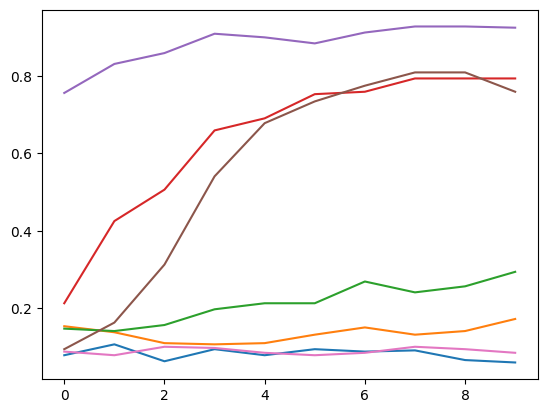

In [16]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]